# SI140@Fall2021 Final Project: Multi-armed Bandit

## metadata

- abstract: performance evalutaion of classical MAB algorithms
- due date: 2022/01/16 11:59am
- author: spinach/hehelego (彭程 [pengcheng2@shanghaitech.edu.cn](mailto://pengcheng2@shanghaitech.edu.cn) 2020533068)

## environment

- OS: arch linux
- kernel: 5.16.0-arch1-1
- Arch: x86-64 (amd64)
- python: version **3.10.1** (require 3.10 for convenient type annotation, see [PEP 484](https://www.python.org/dev/peps/pep-0484/) and [new features in python 3.10](https://docs.python.org/3/whatsnew/3.10.html))
- ipython: version 7.31.0
- numpy: version 1.21.3
- matplotlib: version 3.5.0

```plaintext
# output of "jupyter --version" command
Selected Jupyter core packages...
IPython          : 7.31.0
ipykernel        : 6.6.0
ipywidgets       : 7.6.5
jupyter_client   : 7.1.0
jupyter_core     : 4.9.1
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.5.4
nbconvert        : 6.1.0
nbformat         : 5.1.3
notebook         : 6.4.4
qtconsole        : not installed
traitlets        : 5.1.0
```

## table of contents

- multi-armed bandit framework setup
- implementation of the three appointed classical bandit learning algorithms
- implementation of several more algorithms
- simulation and visualization

The above sections can be found in this jupyter notebook,
while the discussion section can be found in `report.pdf`.

- performance analysis and comparison
- insight on exploration-exploitation trade-off

And we have included two multi-armed bandit variants.

- algorithm for MAB problem with dependent arms
- algorithm for MAB problem with bounded cost 

## code style

- multiple statement in one line is allowed
- identifier for variable      `snake_case`
- identifier for constant      `SANKE_CASE`
- identifier for function      `snake_case`
- identifier for class         `CamelCase`
- identifier for method        `snake_case`
- identifier for property      `snake_case`
- identifier for class method  `snake_case`
- identifier for static method `snake_case`

## section: MAB setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import numpy.typing as npt
import abc
import typing

# the (pesudo) random number generator
rng = npr.Generator(npr.MT19937(19260817))


def natural_number_stream(start: int = 0) -> typing.Iterator[int]:
    r'''
    generate a natural number stream [start, start+1, start+2, ...]
    '''
    while True:
        yield start
        start += 1


def argmax(xs: typing.Iterable) -> int:
    r'''
    index of the maximum element
    \text{GetFirstComponent}( max_{\text{CompareSecondComponent}}( index,value ) )
    '''
    return max(zip(natural_number_stream(), xs), key=lambda kv: kv[1])[0]


def argmin(xs: typing.Iterable) -> int:
    r'''
    index of the minimum element
    \text{GetFirstComponent}( min_{\text{CompareSecondComponent}}( index,value ) )
    '''
    return max(zip(natural_number_stream(), xs), key=lambda kv: -kv[1])[0]


class Sampling:
    r'''
    sampling named distribution

    methods for single sample generation:
    - uniform(a,b):        $\mathrm{Unif}(a,b)$
    - bernoulli(p):        $\mathrm{Bern}(p)$
    - exponential(rate):   $\mathrm{Expo}(\lambda)$, where rate is the value of $\lambda$ parameter.
    - gamma(a,rate):       $\mathrm{Gamma}(a,\lambda)$, where $the value of parameter $\lambda$ is rate.
    '''

    @staticmethod
    def uniform(a: float = 0, b: float = 1) -> float:
        return a+(b-a)*rng.random()

    @staticmethod
    def uniform_array(size: int, a: float = 0, b: float = 1) -> npt.NDArray[np.float_]:
        return a+(b-a)*rng.random(size)

    @staticmethod
    def bernoulli(prob: float) -> int:
        return 1 if Sampling.uniform() < prob else 0

    @staticmethod
    def exponential(rate: float = 1) -> float:
        return rng.exponential(1/rate)

    @staticmethod
    def gamma(a: float, rate: float = 1) -> float:
        return rng.gamma(a, rate)

    @staticmethod
    def beta(a: float, b: float) -> float:
        return rng.beta(a, b)


class MAB:
    r'''
    the multi-armed bandit
    '''

    def __init__(self, theta: list[float]):
        self.theta = theta[:]
        self.arms = len(theta)

    def pull(self, i: int) -> int:
        return Sampling.bernoulli(self.theta[i])

    def oracle_value(self, n: int) -> float:
        return n*max(self.theta)


class Strategy(abc.ABC):
    r'''
    the abstract base class for bandit algorithms
    '''

    def __init__(self, mab: MAB, n: int):
        self.mab = mab
        self.n = n

    @abc.abstractmethod
    def run(self) -> (int, list[list[float]]):
        '''
        perform one simulation: n pulls.
        return a tuple, where the first component is the total rewards
        and the second component is the learned distribution on each step.
        '''
        ...

    @property
    @abc.abstractmethod
    def profile(self) -> str:
        '''
        return the strategy/algorithm name and value of parameters
        '''
        ...

## section: implementation of classical bandit learning algorithms

In [2]:
class EpsilonGreedy(Strategy):
    def __init__(self, mab: MAB, n: int, eps: float):
        super().__init__(mab, n)
        self._profile = f'$\\epsilon-\mathrm{{Greedy}}(\\epsilon={eps})$'
        self.eps = eps
        self.count = [int(0) for _ in range(mab.arms)]
        self.theta_hat = [float(0) for _ in range(mab.arms)]
        self.estimation: list[list[float]] = [[] for _ in range(n)]

    def run(self) -> tuple[int, list[list[float]]]:
        earn = 0
        for t in range(self.n):
            arm = argmax(self.count)
            if Sampling.bernoulli(self.eps):
                arm = rng.integers(self.mab.arms)
            reward = self.mab.pull(arm)
            earn += reward

            self.count[arm] += 1
            self.theta_hat[arm] += (reward-self.theta_hat[arm])/self.count[arm]
            self.estimation[t] = self.theta_hat[:]

        return (earn, self.estimation)

    @property
    def profile(self) -> str:
        return self._profile


class UpperConfidenceBound(Strategy):
    def __init__(self, mab: MAB, n: int, c: float):
        super().__init__(mab, n)
        self._profile = f'$\mathrm{{UCB}}(c={c})$'
        self.c = c
        self.count = [int(0) for _ in range(mab.arms)]
        self.theta_hat = [float(0) for _ in range(mab.arms)]
        self.estimation: list[list[float]] = [[] for _ in range(n)]

    def run(self) -> tuple[int, list[list[int]]]:
        from math import log, sqrt
        earn = 0
        for t in range(self.mab.arms):
            reward = self.mab.pull(t)
            earn += reward

            self.count[t] = 1
            self.theta_hat[t] = reward
            self.estimation[t] = self.theta_hat[:]

        for t in range(self.mab.arms, self.n):
            arm = argmax(self.theta_hat[i] + self.c*sqrt(2*log(t+1)/self.count[i])
                         for i in range(self.mab.arms))
            reward = self.mab.pull(arm)
            earn += reward

            self.count[arm] += 1
            self.theta_hat[arm] += (reward-self.theta_hat[arm])/self.count[arm]
            self.estimation[t] = self.theta_hat[:]

        return (earn, self.estimation)

    @property
    def profile(self) -> str:
        return self._profile


class ThompsonSampling(Strategy):
    def __init__(self, mab: MAB, n: int, prior: list[tuple[int, int]]):
        super().__init__(mab, n)
        self.beta_parameters = [list(i) for i in prior]
        self.theta_hat = [float(0) for _ in range(mab.arms)]
        self.estimation: list[list[float]] = [[] for _ in range(n)]
        self._profile = f'$\mathrm{{ThompsonSampling}}({prior})$'

    def run(self) -> tuple[int, list[list[float]]]:
        earn = 0
        for t in range(self.n):
            self.theta_hat = [Sampling.beta(a, b)
                              for (a, b) in self.beta_parameters]
            arm = argmax(self.theta_hat)
            reward = self.mab.pull(arm)
            earn += reward

            self.beta_parameters[arm][0] += reward
            self.beta_parameters[arm][1] += 1-reward
            self.estimation[t] = [a/(a+b) for (a,b) in  self.beta_parameters]

        return (earn, self.estimation)

    @property
    def profile(self) -> str:
        return self._profile

## section: several more algorithms

In [3]:
class EpsilonDecreaseGreedy(Strategy):
    def __init__(self, mab: MAB, n: int, eps: float, shrink_factor: float):
        super().__init__(mab, n)
        self._profile = f'$\\epsilon\mathrm{{shrink-Greedy}}(\\epsilon={eps}, r={shrink_factor})$'
        self.eps = eps
        self.shrink_factor = shrink_factor
        self.count = [int(0) for _ in range(mab.arms)]
        self.theta_hat = [float(0) for _ in range(mab.arms)]
        self.estimation: list[list[float]] = [[] for _ in range(n)]

    def run(self) -> tuple[int, list[list[float]]]:
        earn = 0
        for t in range(self.n):
            arm = argmax(self.count)
            if Sampling.bernoulli(self.eps):
                arm = rng.integers(self.mab.arms)
            reward = self.mab.pull(arm)
            earn += reward

            self.count[arm] += 1
            self.theta_hat[arm] += (reward-self.theta_hat[arm])/self.count[arm]
            self.eps *= self.shrink_factor
            self.estimation[t] = self.theta_hat[:]

        return (earn, self.estimation)

    @property
    def profile(self) -> str:
        return self._profile

## section: simulation

Benchmark settings: 

– $N = 6000$.  
– $\epsilon$-greedy with $\epsilon=0.2, 0.4, 0.6, 0.8$.  
– UCB with $c = 2, 6, 9$.  
– Thompson Sampling with  
  $$
  \begin{aligned}
  &\{(\alpha_1,\beta_1)=(1,1), (\alpha_2,\beta_2)=(1,1), (\alpha_3,\beta_3)=(1,1)\}
  \\
  &\{(\alpha_1,\beta_1)=(601,401), (\alpha_2,\beta_2)=(401, 601), (\alpha_3,\beta_3)=(2,3)\}
  \end{aligned}
  $$

| Arm $j$    | $1$   | $2$   | $3$   |
| :---:      | :-:   | :-:   | :-:   |
| $\theta_j$ | $0.8$ | $0.6$ | $0.5$ |


**note**: the simulation (runs on single CPU core) takes about 1.5min to finish on `AMD Ryzen 7 4800U @ 4.2GHz`

In [4]:
plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"] = [20, 6]
plt.rcParams["figure.autolayout"] = True

RUNS = 200
N = 6000
mab = MAB([0.8, 0.6, 0.5])

oracle_value = mab.oracle_value(N)
average = lambda xs: sum(xs) / len(xs)


def strategies() -> list[Strategy]:
    eps_gre: list[Strategy] = [
        EpsilonGreedy(mab, N, 0.2),
        EpsilonGreedy(mab, N, 0.4),
        EpsilonGreedy(mab, N, 0.6),
        EpsilonGreedy(mab, N, 0.8),
    ]
    ucb: list[Strategy] = [
        UpperConfidenceBound(mab, N, 2),
        UpperConfidenceBound(mab, N, 6),
        UpperConfidenceBound(mab, N, 9),
    ]
    ts: list[Strategy] = [
        ThompsonSampling(mab, N, [(1, 1), (1, 1), (1, 1)]),
        ThompsonSampling(mab, N, [(601, 401), (401, 601), (2, 3)]),
    ]
    eps_dec_gre: list[Strategy] = [
        EpsilonDecreaseGreedy(mab, N, 1, 0.95),
        EpsilonDecreaseGreedy(mab, N, 0.5, 0.95),
        EpsilonDecreaseGreedy(mab, N, 0.2, 0.99),
    ]
    return eps_gre + ucb + ts + eps_dec_gre

def once_reward() -> dict[str, int]:
    return {
        i.profile : i.run()[0]
        for i in strategies()
    }

benchmark_reward: dict[str,list[int]] = {i.profile : [] for i in strategies()}
for _ in range(RUNS):
    out = once_reward()
    for (k,v) in out.items():
        benchmark_reward[k].append(v)

### sub section: regret comparison

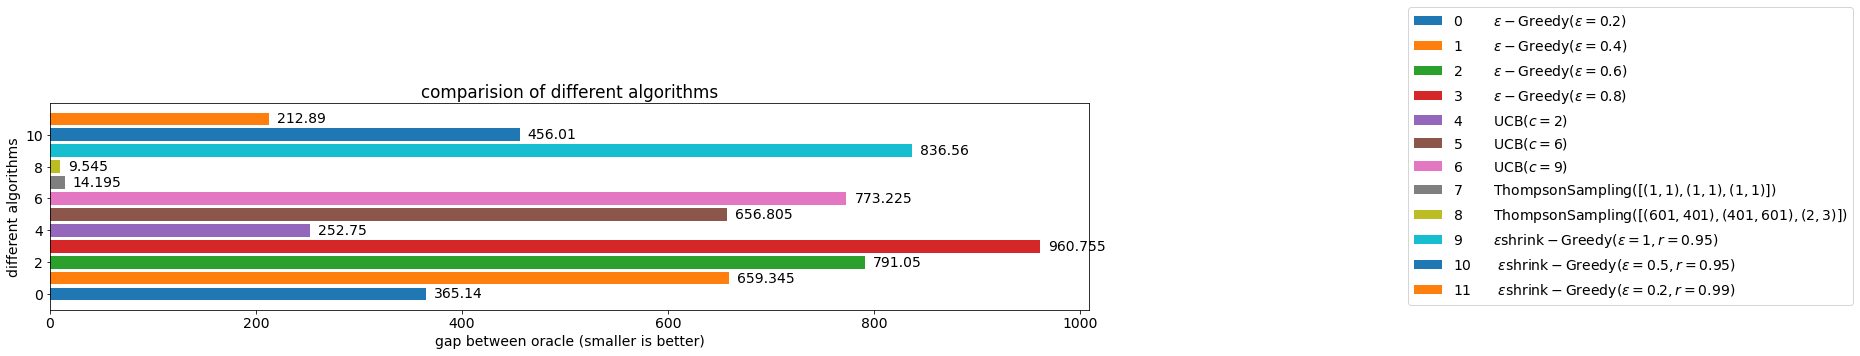

In [5]:
# comparing average reward

fig, ax = plt.subplots()
ax.set_title('comparison of different algorithms')
ax.set_xlabel('gap between oracle (smaller is better)')
ax.set_ylabel('different algorithms')
for (i, (algo, rewards)) in enumerate(benchmark_reward.items()):
    avg = average(rewards)
    bar = ax.barh(i, oracle_value-avg, label=f'{i}\t{algo}')
    ax.bar_label(bar, padding=8)
ax.legend(bbox_to_anchor=(1.3, 1.5))

plt.show()

Based on the simulation result, we can conclude that `Thomposon Sampling` outperforms the `epsilon Greedy` and `Upper Confidence Bound`.

### sub section: learning curve

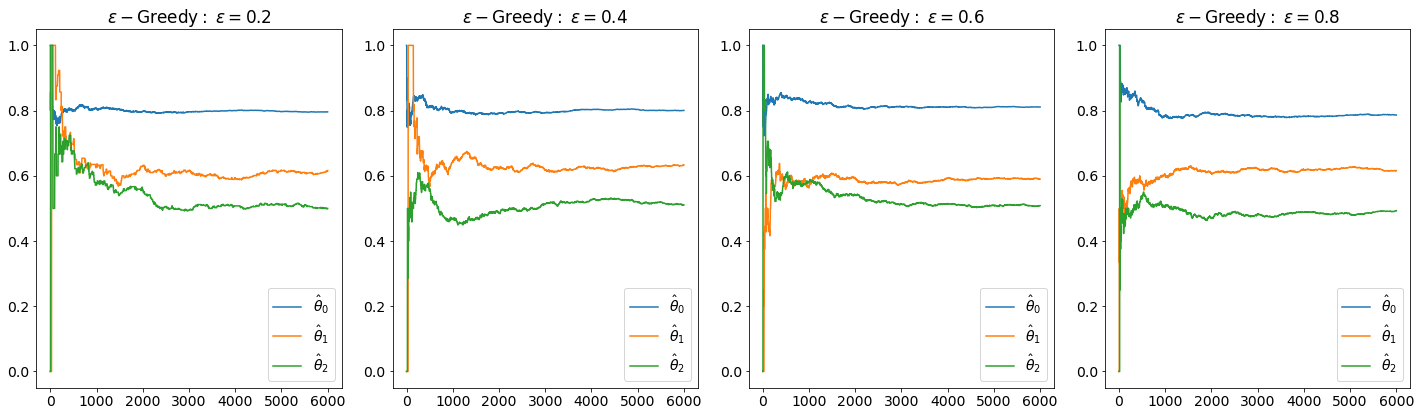

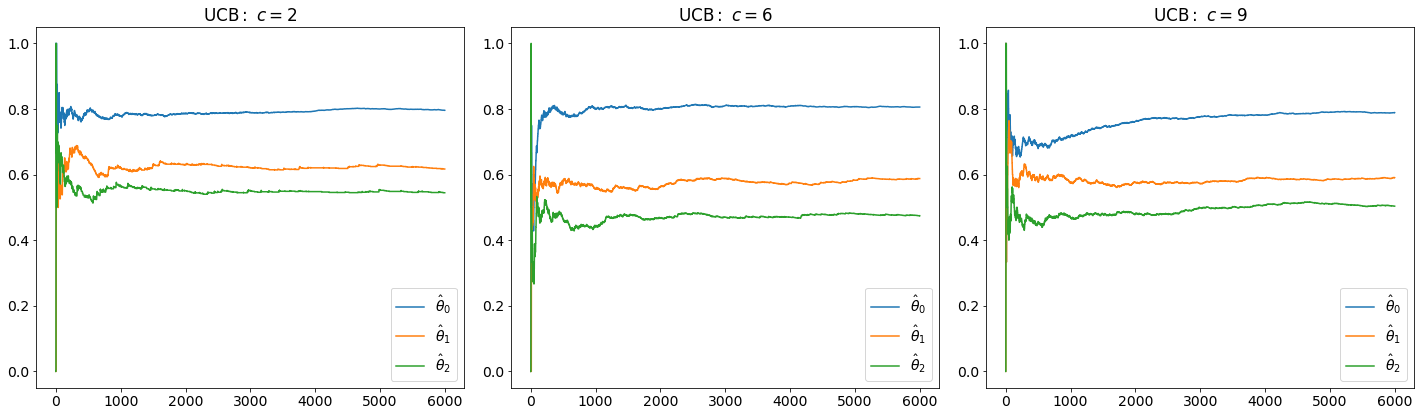

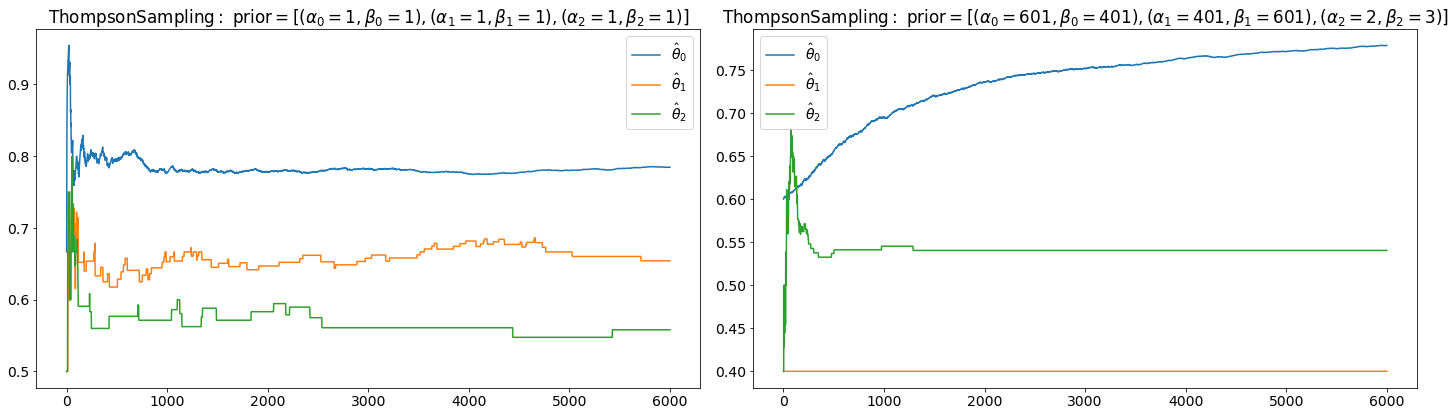

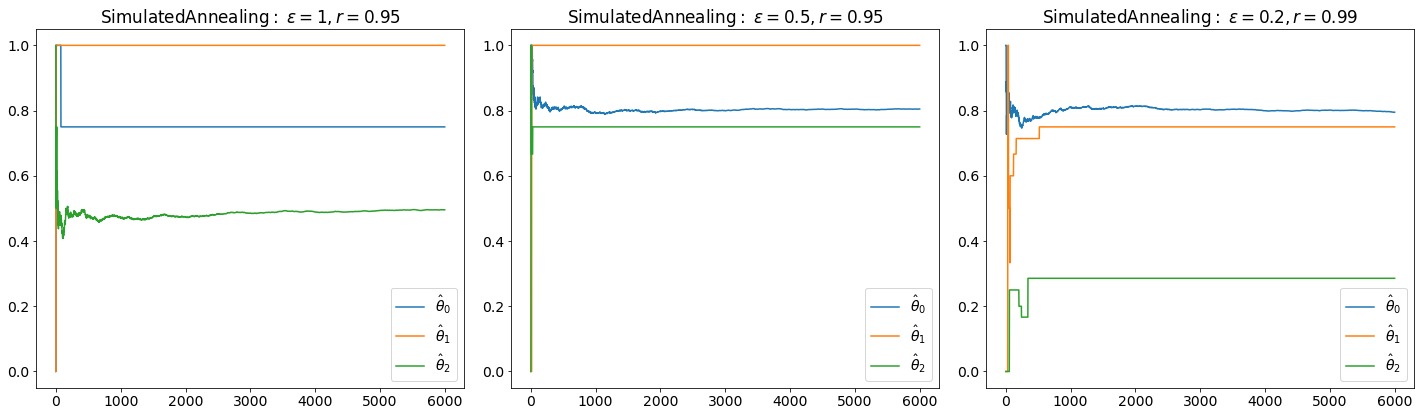

In [6]:
# compare learning accuracy and speed of convergence
eps_gre: list[Strategy] = [
    EpsilonGreedy(mab, N, 0.2),
    EpsilonGreedy(mab, N, 0.4),
    EpsilonGreedy(mab, N, 0.6),
    EpsilonGreedy(mab, N, 0.8),
]
ucb: list[Strategy] = [
    UpperConfidenceBound(mab, N, 2),
    UpperConfidenceBound(mab, N, 6),
    UpperConfidenceBound(mab, N, 9),
]
ts: list[Strategy] = [
    ThompsonSampling(mab, N, [(1, 1), (1, 1), (1, 1)]),
    ThompsonSampling(mab, N, [(601, 401), (401, 601), (2, 3)]),
]
eps_dec_gre: list[Strategy] = [
    EpsilonDecreaseGreedy(mab, N, 1, 0.95),
    EpsilonDecreaseGreedy(mab, N, 0.5, 0.95),
    EpsilonDecreaseGreedy(mab, N, 0.2, 0.99),
]

# epsilon greedy
fig, ax = plt.subplots(1,len(eps_gre))
for (i, algo) in enumerate(eps_gre):
    ax[i].set_title(f'$\\epsilon-\\mathrm{{Greedy}}:\\ \\epsilon={algo.eps}$')
    history = np.array(algo.run()[1]).transpose()
    for (j, data) in enumerate(history):
        ax[i].plot(data, label=f'$\\hat\\theta_{j}$')
    ax[i].legend()

# UCB
fig, ax = plt.subplots(1,len(ucb))
for (i, algo) in enumerate(ucb):
    ax[i].set_title(f'$\\mathrm{{UCB}}:\\ c={algo.c}$')
    history = np.array(algo.run()[1]).transpose()
    for (j, data) in enumerate(history):
        ax[i].plot(data, label=f'$\\hat\\theta_{j}$')
    ax[i].legend()

# Thompson Sampling
fig, ax = plt.subplots(1,len(ts))
for (i, algo) in enumerate(ts):
    prior = ', '.join(f'(\\alpha_{i}={a},\\beta_{i}={b})' for (i,(a,b)) in enumerate(algo.beta_parameters))
    ax[i].set_title(f'$\\mathrm{{ThompsonSampling}}:\\ \\mathrm{{prior}}=\\left[{prior}\\right]$')
    history = np.array(algo.run()[1]).transpose()
    for (j, data) in enumerate(history):
        ax[i].plot(data, label=f'$\\hat\\theta_{j}$')
    ax[i].legend()

# epsilon decrease greedy
fig, ax = plt.subplots(1,len(eps_dec_gre))
for (i, algo) in enumerate(eps_dec_gre):
    ax[i].set_title(f'$\\mathrm{{SimulatedAnnealing}}:\\ \\epsilon={algo.eps},r={algo.shrink_factor}$')
    history = np.array(algo.run()[1]).transpose()
    for (j, data) in enumerate(history):
        ax[i].plot(data, label=f'$\\hat\\theta_{j}$')
    ax[i].legend()

# show all the figures
plt.show()

## section: discussion, extension and generalization

In this section, we will analysis the impact of each (hyper-)parameters and demonstrate our insight on the exploration-exploitation tradeoff.  
After that, we are to introduce two extended variant of the multi-armed bandit problem and modify the UCB algorithm for the new problem settings.

see `report.pdf`  